<a href="https://colab.research.google.com/github/VictoriaOG1/Machine-Learning/blob/main/draft2_proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Librerias
import numpy as np 
import pandas as pd 
import re
import matplotlib.pyplot as plt 
import nltk
import gensim
import sklearn
import tensorflow as tf
from sklearn.metrics import classification_report, roc_auc_score
from tensorflow import keras 
from sklearn.manifold import TSNE
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import RepeatedStratifiedKFold
from tabulate import tabulate
from nltk.corpus import stopwords
from gensim.models import Word2Vec
#nltk.download('stopwords')

In [ ]:
#Read dataset
dataset = pd.read_csv("Tweets.csv")
dataset.columns = ['textID','text','selected_text', 'sentiment']

#Get columns selected_text and sentiment
dataset_text_x = dataset[['selected_text']]
dataset_target_y = dataset[['sentiment']]
#Data visualization 
headers = ['selected_text', 'sentiment']
complete_table = np.column_stack([dataset_text_x, dataset_target_y]) 
table = tabulate(complete_table[0:19,:], headers, tablefmt="fancy_grid")
print ("Visualizing first 20 rows")
print(table)


Visualizing first 20 rows
╒════════════════════════════════════════════════════════════════════════════════════════════════════════════╤═════════════╕
│ selected_text                                                                                              │ sentiment   │
╞════════════════════════════════════════════════════════════════════════════════════════════════════════════╪═════════════╡
│ I`d have responded, if I were going                                                                        │ neutral     │
├────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────────┤
│ Sooo SAD                                                                                                   │ negative    │
├────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────────┤
│ bullying me                                                                                      

In [ ]:
# Get columns selected_text and sentiment
selected_text = np.array(dataset['selected_text'].astype(str))
sentiment = np.array(dataset['sentiment'])

# Initialize an empty list to hold the cleaned selected text
cleaned_selected_text = []

# Define a regular expression pattern to match punctuation, symbols, and URLs
pattern = r'[^\w\s]|http\S+'

# Iterate through each selected text in the dataset
for text in selected_text:
    # Use regular expressions to remove punctuation, symbols, and URLs
    cleaned_text = re.sub(pattern, '', text)
    # Append the cleaned selected text to the list and lowercase the text
    cleaned_selected_text.append(cleaned_text.lower())

# Print the first 10 cleaned selected texts
print(cleaned_selected_text[:20])

['id have responded if i were going', 'sooo sad', 'bullying me', 'leave me alone', 'sons of ', '  some shameless plugging for the best rangers forum on earth', 'fun', 'soooo high', 'both of you', 'wow u just became cooler', 'as much as i love to be hopeful i reckon the chances are minimal p im never gonna get my cake and stuff', 'like', 'dangerously', 'lost', 'test test from the lg env2', 'uh oh i am sunburned', 'sigh', 'sick', 'onna', 'hes just not that into you']


In [ ]:
stop_words = set(stopwords.words('english'))
tokens = []
clean_sentiment = []
for text in range(len(cleaned_selected_text)):
  clean_text = list(cleaned_selected_text[text].split())
  clean_tokens = [wrd for wrd in clean_text if wrd not in stop_words and len(wrd) > 1]
  clean_tokens = [wrd for wrd in clean_text if wrd not in stop_words]
  if len(clean_tokens) > 0:
    tokens.append(clean_tokens)
    if sentiment[text] == "negative":
      clean_sentiment.append(0)
    if sentiment[text] == "neutral":
      clean_sentiment.append(1)
    if sentiment[text] == "positive":
      clean_sentiment.append(2)
print(tokens)
print(len(tokens))
print(len(clean_sentiment))


[['id', 'responded', 'going'], ['sooo', 'sad'], ['bullying'], ['leave', 'alone'], ['sons'], ['shameless', 'plugging', 'best', 'rangers', 'forum', 'earth'], ['fun'], ['soooo', 'high'], ['wow', 'u', 'became', 'cooler'], ['much', 'love', 'hopeful', 'reckon', 'chances', 'minimal', 'p', 'im', 'never', 'gonna', 'get', 'cake', 'stuff'], ['like'], ['dangerously'], ['lost'], ['test', 'test', 'lg', 'env2'], ['uh', 'oh', 'sunburned'], ['sigh'], ['sick'], ['onna'], ['hes'], ['oh', 'marly', 'im', 'sorry', 'hope', 'find', 'soon', '3', '3'], ['interesting'], ['cleaning', 'house', 'family', 'comming', 'later', 'today'], ['gotta', 'restart', 'computer', 'thought', 'win7', 'supposed', 'put', 'end', 'constant', 'rebootiness'], ['see', 'wat', 'mean', 'bout', 'foll0w', 'friidays', 'called', 'lose', 'f0llowers', 'friday', 'smh'], ['free', 'fillin', 'app', 'ipod', 'fun', 'im', 'addicted'], ['im', 'sorry'], ['internet'], ['fun'], ['power', 'back', 'working'], ['quiteheavenly'], ['hope'], ['well', 'much', 'unh

In [ ]:
model_w2v = Word2Vec(sentences=tokens, vector_size=100, window=5, min_count=1, workers=4)

model_w2v.train(tokens, total_examples= len(tokens), epochs=20)

(2109643, 2282360)

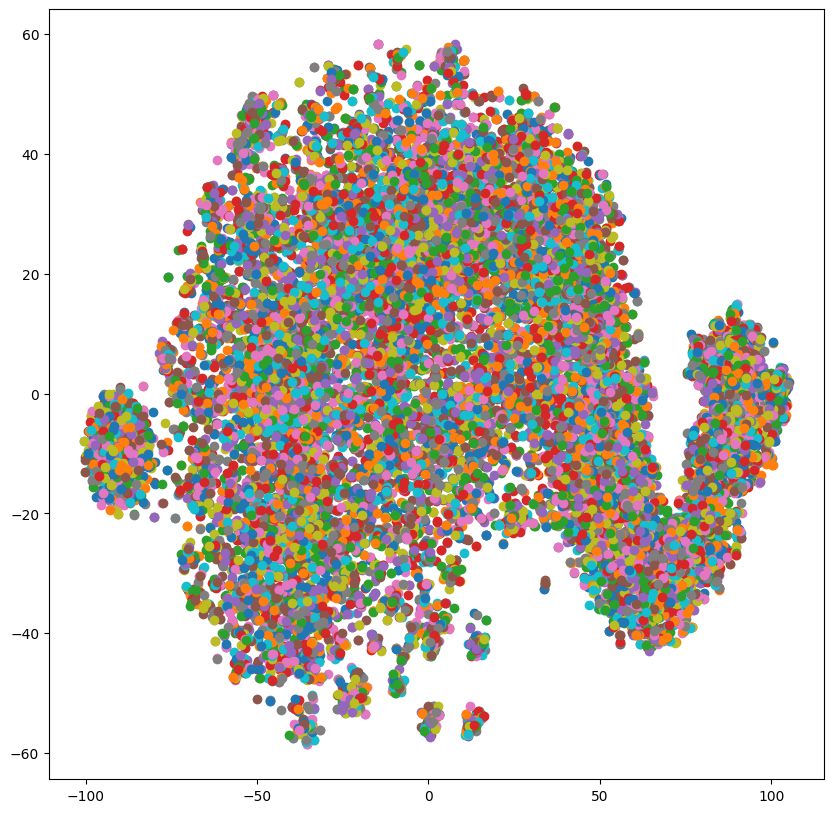

In [ ]:
vocabulary = list(model_w2v.wv.index_to_key)
# Visualize embeddings
def plot_embeddings(model):
    # Get word vectors for each word in vocabulary
    X = model.wv[model.wv.index_to_key]
    
    # Use t-SNE to reduce dimensionality of embeddings to 2D
    tsne = TSNE(n_components=2)
    X_tsne = tsne.fit_transform(X)
    
    # Plot embeddings
    plt.figure(figsize=(10, 10))
    for i in range(len(vocabulary)):
        plt.scatter(X_tsne[i, 0], X_tsne[i, 1])
    plt.show()

plot_embeddings(model_w2v)

In [ ]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v.wv[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

In [ ]:
wordvec_arrays = np.zeros((len(tokens), 100))

for i in range(len(tokens)):
    wordvec_arrays[i,:] = word_vector(tokens[i], 100)
    
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(27279, 100)

In [ ]:
print(wordvec_arrays)

[[ 0.23461156  0.88962944  0.20025054 ...  0.29013223  0.2129262
  -0.22181316]
 [ 0.18986933  0.47050104 -0.14063882 ... -0.96981663  0.27679279
  -0.39586926]
 [ 0.00395195 -0.00281215  0.00246438 ...  0.0089486   0.00243919
  -0.00579168]
 ...
 [-1.07596654  0.60424608  0.21960761 ... -0.29252354 -0.21385239
   0.1840555 ]
 [-0.04737022  0.26447183  0.19471806 ... -0.42416656  0.47989678
  -0.0771696 ]
 [-0.0804865   0.50783538  0.02921117 ...  0.16212187  0.02070895
  -0.03628137]]


In [ ]:
X = np.array(wordvec_arrays)
y = np.array(clean_sentiment)

accuracy_scores = []
auc_roc_scores = []
precision_scores = []
recall_scores = []
f1_scores_macro = []
f1_scores_weighted = []

data_selection = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state = 36851234)

model = tf.keras.models.Sequential([
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(512, activation='relu'),
                                    tf.keras.layers.Dense(512, activation='relu'),
                                    tf.keras.layers.Dense(3, activation='softmax')
                                    ])

model.compile(optimizer = tf.optimizers.Adam(),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])

for i, (train_index, test_index) in enumerate(data_selection.split(X,y)):
  model.fit(X[train_index], y[train_index], batch_size = 128, epochs=5, verbose= False)
  model.evaluate(X[test_index], y[test_index], verbose=0)
  y_predict = model.predict(X[test_index])
  y_predict_labels = np.argmax(y_predict, axis=1)
  # Compute classification report
  report = classification_report(y[test_index], y_predict_labels, output_dict=True)
    
  # Append the scores to the corresponding list
  accuracy_scores.append(report['accuracy'])
  precision_scores.append(report['macro avg']['precision'])
  recall_scores.append(report['macro avg']['recall'])
  auc_roc_scores.append(roc_auc_score(y[test_index], y_predict, multi_class='ovo', average='macro'))
  f1_scores_macro.append(report['macro avg']['f1-score'])
  f1_scores_weighted.append(report['weighted avg']['f1-score'])

# Print the results
print(f'Accuracy: {np.mean(accuracy_scores):.3f} ± {np.std(accuracy_scores):.3f}')
print(f'AUC ROC: {np.mean(auc_roc_scores):.3f} ± {np.std(auc_roc_scores):.3f}')
print(f'Precision: {np.mean(precision_scores):.3f} ± {np.std(precision_scores):.3f}')
print(f'Recall: {np.mean(recall_scores):.3f} ± {np.std(recall_scores):.3f}')
print(f'F1 score (macro avg): {np.mean(f1_scores_macro):.3f} ± {np.std(f1_scores_macro):.3f}')
print(f'F1 score (weighted avg): {np.mean(f1_scores_weighted):.3f} ± {np.std(f1_scores_weighted):.3f}')


86/86 [==============================] - 0s 2ms/step
Accuracy: 0.946 ± 0.049
AUC ROC: 0.989 ± 0.019
Precision: 0.945 ± 0.048
Recall: 0.944 ± 0.051
F1 score (macro avg): 0.944 ± 0.050
F1 score (weighted avg): 0.946 ± 0.049


In [ ]:
score = model.evaluate(X[test_index], y[test_index])
print(score)

86/86 [==============================] - 0s 2ms/step - loss: 0.0648 - accuracy: 0.9802
[0.06477349996566772, 0.9801980257034302]
